# Análisis de residuos

> Análisis de residuos para el primer día predicho en el horizonte.

In [ ]:
# [Configuración] Importaciones
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import bds


In [ ]:
# [Configuración] Lectura de archivos

# Cargar todos los archivos de residuos
archivos = glob.glob("metricas/Residuos_ventana*.csv")
archivos = sorted(archivos, key=lambda x: int(x.split("ventana")[1].split(".")[0]))
residuos_por_ventana = {int(f.split("ventana")[1].split(".")[0]): pd.read_csv(f) for f in archivos}

In [ ]:
# [Resumen] Descriptivo de residuos
for ventana, df in residuos_por_ventana.items():
    print(f"\n📦 Ventana {ventana}")
    print(df["residuo_h1"].describe().round(4))


📦 Ventana 7
count    555.0000
mean      -0.0003
std        0.1938
min       -1.7662
25%       -0.0592
50%       -0.0115
75%        0.0488
max        2.7337
Name: residuo_h1, dtype: float64

📦 Ventana 14
count    290.0000
mean       0.0250
std        0.1305
min       -0.5262
25%       -0.0484
50%        0.0104
75%        0.0956
max        0.5236
Name: residuo_h1, dtype: float64

📦 Ventana 21
count    195.0000
mean       0.0073
std        0.0707
min       -0.2264
25%       -0.0363
50%        0.0021
75%        0.0392
max        0.2972
Name: residuo_h1, dtype: float64

📦 Ventana 28
count    146.0000
mean       0.0201
std        0.2402
min       -0.3808
25%       -0.0904
50%       -0.0112
75%        0.0737
max        1.4838
Name: residuo_h1, dtype: float64


La distribución de residuos arroja que la ventana de 7 días tiene la mayor dispersión y un rango extremo (±2.7), lo que sugiere que el modelo está capturando variabilidad pero también generando residuos extremos. Esto puede indicar sobreajuste o sensibilidad a ruido. La ventana 21 muestra la menor desviación estándar y una media cercana a cero, lo que sugiere buena estabilidad y balance, confirmando que esta es la ventana que mejor resultado ofrece para la predicción de volatilidad. Por otro lado, la ventana 28 tiene una desviación alta pero un rango más contenido que ventana 7, lo que podría reflejar mayor complejidad en la dinámica temporal.
Todas las medias están cerca de cero, lo cual es deseable en residuos.

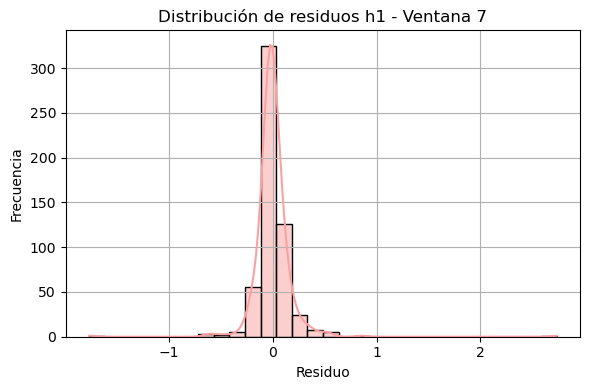

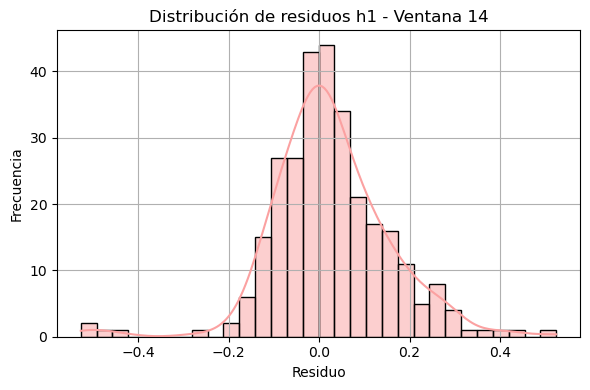

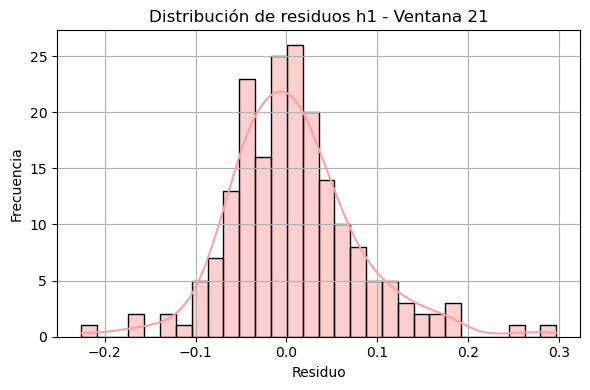

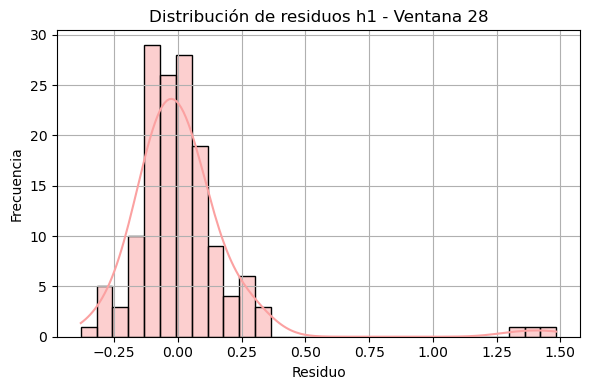

In [29]:
# [Gráfico] Distribución de residuos para el horizonte 1
for ventana, df in residuos_por_ventana.items():
    plt.figure(figsize=(6, 4))
    sns.histplot(df["residuo_h1"], kde=True, bins=30, color= '#FBA1A1')
    plt.title(f"Distribución de residuos h1 - Ventana {ventana}")
    plt.xlabel("Residuo")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# [Test] Prueba Shapiro - BDS - Ljung-Box
for ventana, df in residuos_por_ventana.items():
    residuos = df["residuo_h1"].dropna()

    stat_shapiro, p_shapiro = shapiro(residuos)
    stat_bds = bds(residuos)
    lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)

    print(f"\n🧪 Ventana {ventana}")
    print(f"Shapiro-Wilk: \n Estadístico={stat_shapiro:.4f},    P-valor={p_shapiro:.4f}")
    print(f"BDS: \n Estadístico={stat_bds[0]:.4f},  P-valor={stat_bds[1]:.4f}")
    print(f"Ljung-Box (lag 10): \n P-valor={lb_test['lb_pvalue'].values[0]:.4f}")


🧪 Ventana 7
Shapiro-Wilk: 
 Estadístico=0.6092,    P-valor=0.0000
BDS: 
 Estadístico=-0.2347,  P-valor=0.8145
Ljung-Box (lag 10): 
 P-valor=0.1599

🧪 Ventana 14
Shapiro-Wilk: 
 Estadístico=0.9425,    P-valor=0.0000
BDS: 
 Estadístico=-1.3053,  P-valor=0.1918
Ljung-Box (lag 10): 
 P-valor=0.0000

🧪 Ventana 21
Shapiro-Wilk: 
 Estadístico=0.9607,    P-valor=0.0000
BDS: 
 Estadístico=1.1136,  P-valor=0.2654
Ljung-Box (lag 10): 
 P-valor=0.0004

🧪 Ventana 28
Shapiro-Wilk: 
 Estadístico=0.6428,    P-valor=0.0000
BDS: 
 Estadístico=-1.2602,  P-valor=0.2076
Ljung-Box (lag 10): 
 P-valor=0.0017


- Normalidad: 
    Todos los residuos fallan el test de Shapiro-Wilk (p < 0.05), indicando que no siguen una distribución normal. 

- Dependencia no lineal (BDS):
    La ventana 7 tiene p > 0.8 → no hay evidencia de estructura no lineal.
    Las demás ventanas tienen p valor entre 0.19 y 0.26, es decir, no se rechaza la hipótesis nula, pero tampoco se confirma independencia total.

- Autocorrelación (Ljung-Box):
    La ventana 7 pasa el test (p > 0.05), pero las demás lo fallan. Hay evidencia de autocorrelación residual, especialmente en ventanas más largas.

In [ ]:
# [Resumen] Promedio de residuos por fold
for ventana, df in residuos_por_ventana.items():
    promedio_por_fold = df.groupby("fold")["residuo_h1"].mean().round(4)
    print(f"\n📊 Promedio residuos h1 por fold - Ventana {ventana}")
    print(promedio_por_fold)


📊 Promedio residuos h1 por fold - Ventana 7
fold
0    0.0031
1   -0.0160
2   -0.0177
3   -0.0214
4    0.0504
Name: residuo_h1, dtype: float64

📊 Promedio residuos h1 por fold - Ventana 14
fold
0    0.0272
1    0.0170
2    0.0614
3   -0.0021
4    0.0213
Name: residuo_h1, dtype: float64

📊 Promedio residuos h1 por fold - Ventana 21
fold
0    0.0190
1    0.0175
2   -0.0084
3    0.0109
4   -0.0027
Name: residuo_h1, dtype: float64

📊 Promedio residuos h1 por fold - Ventana 28
fold
0    0.0539
1    0.0452
2    0.0393
3   -0.0097
4   -0.0264
Name: residuo_h1, dtype: float64
